In [218]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from random import seed
from datetime import datetime

In [82]:
# Loading data

games = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/games.csv")
players = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/players.csv")
plays = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/plays.csv")
tackles = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/tackles.csv")
week2 = pd.read_csv("/Users/cyn/Desktop/nfl-big-data-bowl-2024/tracking_week_2.csv")

In [201]:
# Merging Data to get dataset

dataset = week2.merge(players, on = ['nflId', 'displayName'], how = 'outer').merge(games, on = 'gameId' , how = 'outer').merge(tackles, on = ['gameId', 'nflId', 'playId'] , how = 'outer').merge(plays, left_on = ['gameId', 'playId', 'nflId'], right_on = ['gameId', 'playId', 'ballCarrierId'] , how = 'inner')

In [202]:
dataset['Foul'] = np.empty(len(dataset))
for i in range(len(dataset)):
    if pd.isna(dataset.foulNFLId1[i]) and pd.isna(dataset.foulNFLId2[i]):
        dataset.Foul[i] = 0
    else:
        dataset.Foul[i] = 1

/var/folders/1v/cty37wrs42196x0dzbz8j4jw0000gn/T/ipykernel_40187/1847695133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.Foul[i] = 0
/var/folders/1v/cty37wrs42196x0dzbz8j4jw0000gn/T/ipykernel_40187/1847695133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.Foul[i] = 1


In [203]:
dataset = dataset.drop(axis = 1, columns = ['foulNFLId1', 'foulNFLId2']) #check column name or axis

In [327]:
seed(47)
df = dataset.sample(500)

In [328]:
df = pd.get_dummies(df, columns = ['height','tackle', 'assist','forcedFumble', 'pff_missedTackle', 'foulName1', 'passResult', 'offenseFormation','foulName2', 'playDirection'], drop_first = True)

# Looking at Raven Data

In [329]:
RAV = df[df.club == 'BAL']

In [330]:
RAV.T

,6420,7003,6442,5623,6085,5682,5919,6565,6123,6216,6427
gameId,2022091800.0,2022091800.0,2022091800.0,2022091800.0,2022091800.0,2022091800.0,2022091800.0,2022091800.0,2022091800.0,2022091800.0,2022091800.0
playId,3089.0,405.0,3089.0,3684.0,3158.0,426.0,2801.0,1852.0,3179.0,1459.0,3089.0
nflId,52500.0,42469.0,52500.0,43362.0,46101.0,45268.0,46101.0,47896.0,46101.0,46155.0,52500.0
displayName,Devin Duvernay,Mike Davis,Devin Duvernay,Kenyan Drake,Lamar Jackson,Patrick Ricard,Lamar Jackson,Justice Hill,Lamar Jackson,Mark Andrews,Devin Duvernay
frameId,16.0,22.0,38.0,36.0,43.0,47.0,3.0,38.0,22.0,14.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...
offenseFormation_PISTOL,0,1,0,1,0,0,0,0,0,1,0
offenseFormation_SHOTGUN,0,0,0,0,0,0,1,1,1,0,0
offenseFormation_SINGLEBACK,1,0,1,0,0,0,0,0,0,0,1
offenseFormation_WILDCAT,0,0,0,0,0,0,0,0,0,0,0


In [331]:
RAV.shape

(11, 83)

In [332]:
fb_data = df[df.club != 'BAL']

In [333]:
fb_data.shape

(489, 83)

# Train and Test Data

In [334]:
len(fb_data) * .7, len(fb_data) * .3

(342.29999999999995, 146.7)

In [335]:
X_train, X_test, y_train, y_test = train_test_split(fb_data.drop(columns = 'expectedPointsAdded'), fb_data.expectedPointsAdded, test_size = .3, random_state = 47)

In [336]:
X_test.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,x,y,...,foulName1_Ineligible Downfield Pass,foulName1_Offensive Holding,passResult_R,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,playDirection_right
56353,2.022092e+09,904.0,47836.0,Miles Sanders,3.0,2022-09-19 21:05:37.599999,26.0,PHI,39.47,26.49,...,0,0,0,0,0,0,0,1,0,1
19594,2.022092e+09,1450.0,37101.0,Mark Ingram,1.0,2022-09-18 13:58:10.400000,22.0,NO,34.73,29.95,...,0,0,0,0,0,0,0,1,0,1
34384,2.022092e+09,2329.0,46377.0,Jeffery Wilson,18.0,2022-09-18 17:54:03.000000,22.0,SF,85.13,22.96,...,0,0,0,0,0,0,1,0,0,1
7487,2.022092e+09,1367.0,44817.0,Corey Davis,3.0,2022-09-18 13:52:16.799999,84.0,NYJ,69.68,25.78,...,0,0,0,0,0,0,1,0,0,0
42390,2.022092e+09,2943.0,53464.0,Javonte Williams,24.0,2022-09-18 18:36:33.099999,33.0,DEN,52.11,24.92,...,0,0,0,0,0,0,0,1,0,0


### Shape of testing data

In [337]:
X_train.shape, X_test.shape

((342, 82), (147, 82))

In [338]:
y_train.shape, y_test.shape

((342,), (147,))

In [341]:
str_list = df.select_dtypes(include = object).columns
id_train = X_train[str_list]
id_test = X_test[str_list]
X_train.drop(columns= str_list, inplace= True)
X_test.drop(columns=str_list, inplace= True)

In [342]:
X_train.dtypes

gameId                         float64
playId                         float64
nflId                          float64
frameId                        float64
jerseyNumber                   float64
                                ...   
offenseFormation_PISTOL          uint8
offenseFormation_SHOTGUN         uint8
offenseFormation_SINGLEBACK      uint8
offenseFormation_WILDCAT         uint8
playDirection_right              uint8
Length: 64, dtype: object

## Looking at y mean v. predicted y

In [343]:
train_mean = y_train.mean()
train_mean

0.26772639931578945

In [344]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[0.2677264]])

## Metrics

 #### R-Squared

In [345]:
y_tr_pred = train_mean * np.ones(len(y_train))
y_te_pred = train_mean * np.ones(len(y_test))

In [346]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0010040831646398463)

 #### Mean Absolute Error

In [347]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.8974013418531857, 0.80176235173541)

 #### Mean Squared Error

In [348]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1.5216089585846293, 1.1832595383969604)

## Models

In [349]:
X_defaults_median = X_train.median()
X_defaults_median

gameId                         2.022092e+09
playId                         2.081000e+03
nflId                          4.785300e+04
frameId                        2.200000e+01
jerseyNumber                   2.400000e+01
                                   ...     
offenseFormation_PISTOL        0.000000e+00
offenseFormation_SHOTGUN       0.000000e+00
offenseFormation_SINGLEBACK    0.000000e+00
offenseFormation_WILDCAT       0.000000e+00
playDirection_right            0.000000e+00
Length: 64, dtype: float64

In [350]:
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

In [351]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [353]:
lm = LinearRegression()
lm.fit(X_tr_scaled, y_train)

LinearRegression()

In [ ]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [355]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.0, -0.0010040831646398463)

In [356]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(0.8974013418531857, 0.80176235173541)

In [357]:
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(1.5216089585846293, 1.1832595383969604)

 #### Linear Regression Pipes

In [358]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [359]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [360]:
pipe_y_tr_pred = pipe.predict(X_train)
pipe_y_te_pred = pipe.predict(X_test)

In [361]:
r2_score(y_train, pipe_y_tr_pred), r2_score(y_test, pipe_y_te_pred)

(0.7530580589396172, 0.5016849809480979)

In [362]:
mean_absolute_error(y_train, pipe_y_tr_pred), mean_absolute_error(y_test, pipe_y_te_pred)

(0.4129418639196506, 0.49926059916440596)

In [364]:
print('The earlier result was', median_mae)

The earlier result was (0.8974013418531857, 0.80176235173541)


In [363]:
mean_squared_error(y_train, pipe_y_tr_pred), mean_squared_error(y_test, pipe_y_te_pred)

(0.375749069767756, 0.5890445497040455)

In [365]:
print('The earlier result was', median_mse)

The earlier result was (1.5216089585846293, 1.1832595383969604)


In [377]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5)
cv_scores = cv_results['test_score']
cv_scores

array([-6.18389636e+15, -1.61490957e+15, -1.62014561e+20,  4.05386715e-01,
       -3.50319195e+22])

In [378]:
np.mean(cv_scores), np.std(cv_scores)

(-7.038788364142423e+21, 1.3996706195576761e+22)

In [379]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([-3.50322008e+22,  2.09546240e+22])

In [371]:
pipe2 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [372]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x14fafd4e0>)),
                ('linearregression', LinearRegression())])

In [373]:
pipe2_y_tr_pred = pipe2.predict(X_train)
pipe2_y_te_pred = pipe2.predict(X_test)

In [374]:
r2_score(y_train, pipe2_y_tr_pred), r2_score(y_test, pipe2_y_te_pred)

(0.6898426857822528, 0.5711680532867799)

In [375]:
mean_absolute_error(y_train, pipe2_y_tr_pred), mean_absolute_error(y_test, pipe2_y_te_pred)

(0.46568967492667135, 0.4428346873020805)

In [380]:
cv_results = cross_validate(pipe2, X_train, y_train, cv=5)
cv_scores = cv_results['test_score']
cv_scores

array([0.672762  , 0.6250244 , 0.56523538, 0.60010436, 0.68649554])

In [381]:
np.mean(cv_scores), np.std(cv_scores)

(0.6299243369020271, 0.045018372067808565)

In [382]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.54, 0.72])

 #### Grid Search

In [387]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [389]:
lr_grid_cv = GridSearchCV(pipe2, param_grid=grid_params, cv=5, n_jobs=-1)

In [390]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x14fafd4e0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [391]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [394]:
lr_grid_cv.best_params_

{'selectkbest__k': 2}

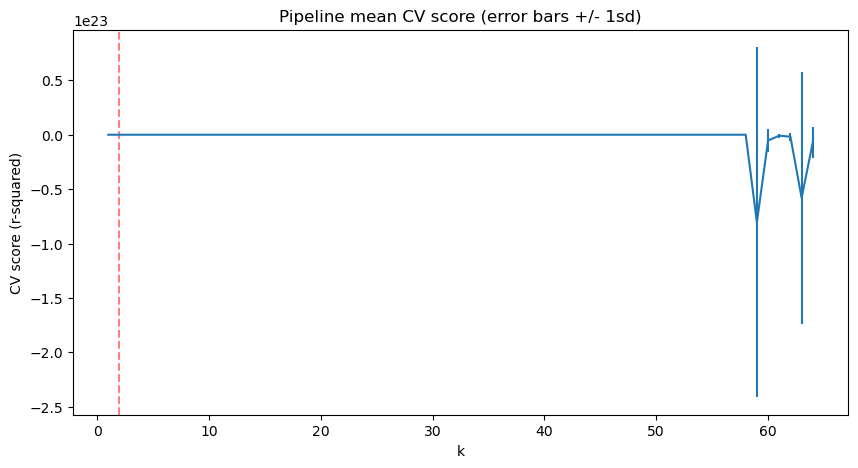

In [395]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [397]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index= features).sort_values(ascending= False)

playResult              0.871948
prePenaltyPlayResult    0.152139
dtype: float64

 #### Random Forest Model

In [398]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy= 'median'),
    StandardScaler(),
    RandomForestRegressor(random_state= 47)
)

In [399]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv= 5)

In [400]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.83137124, 0.7762698 , 0.7570657 , 0.62626945, 0.76593562])

In [401]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.7513823598922437, 0.06769777354049485)

In [402]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [403]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid= grid_params, cv= 5, n_jobs=-1)

In [404]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [405]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 112,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [406]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.83092049, 0.77379551, 0.75813195, 0.64747384, 0.76524042])

In [407]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.7551124410757751, 0.05965514198474449)

Text(0.5, 1.0, 'Best random forest regressor feature importances')

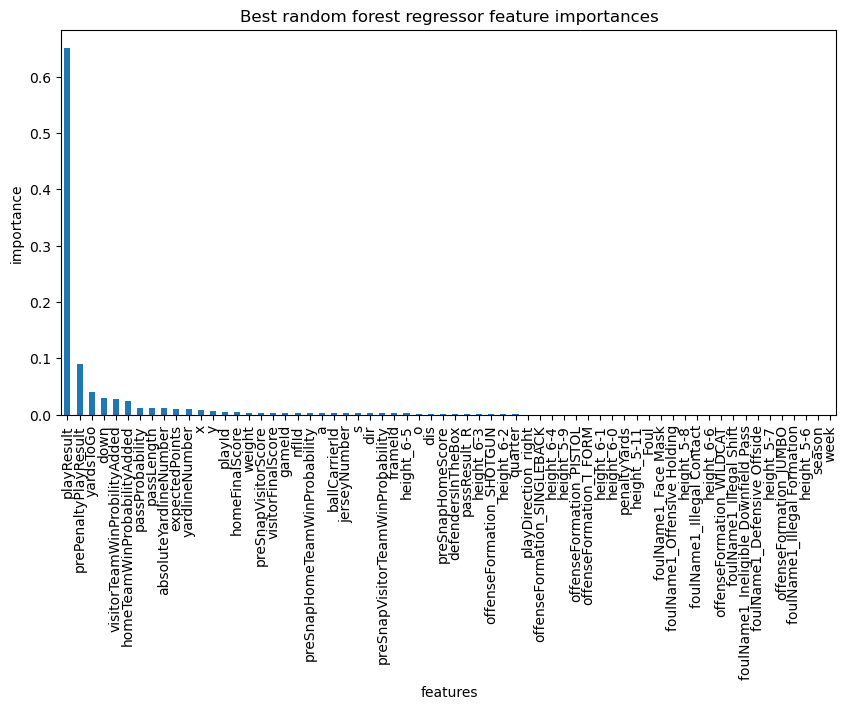

In [408]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances')

The 4 best features are:

- playResult
- prePenaltyPlayResult
- yardsToGo
- down